# Movie Genre Prediction by Poster
The goal of this notebook is to try to predict a movie's genre by looking at the poster it has.
To achieve this goal I will:
1. Use [The Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) to get 45k movie titles.
2. Use the [omdb_api](http://www.omdbapi.com/) to get the posters for the movies and store them localy.
3. Use Tensorflow and Keras to create a ConvNet that will classify the images.

## Project Structure
1. Data loading, acquisition and cleaning
2. Model creation.
3. Model evaluation.

In [1]:
# Library Loading
import json
from urllib.parse import urlencode
import requests
import pandas as pd
import os
import numpy as np
from shutil import move
import matplotlib.pyplot as plt


# Loading the 
OMDB_KEY = json.loads(open('apikeys/apikey.json').read())['key']

## 1. Data loading, acquisition and cleaning

### 1.1 Loading 'The Movies' dataset.

In [2]:
the_movies = pd.read_csv('./datasets/The_Movies/movies_metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 1.2 Defining the API functions

In [3]:
def get_movie(imdbid):
    '''Gets the movie by imdb id and returns json with the title, genre and imdb id.
       Input args:
       - imdbid: the imdb id of the character
       Returns:
       - If the API responds succesfully return the genres, otherwise return NA
    - 
    '''
    url = 'http://www.omdbapi.com/?apikey=' + OMDB_KEY + '&i=' + str(imdbid)
    r = requests.get(url)
    if r.status_code == 200:
        movie_json = r.json()
        return movie_json['Genre']
    else:
        return 'NA'

def get_poster(imdb_id, path, genre, dataset_type, image_heigth, item_id):
    '''Gets the movie poster as a jpg and saves it to the path.
       Input args:
       - imbd_id: the imdb id of the movie,
       - path: where the dataset will be stored,
       - genre: the genre of the movie,
       - dataset_type: whether we are creating the training or testing,
       - image_height: the height of the poster - api query
       - item_id: identifier to attach to the filename
       Returns:
       - None
    '''
    # construct the requests url
    url = 'http://img.omdbapi.com/?apikey=' + OMDB_KEY + '&i=' + str(imdb_id) + '&h=' + str(image_heigth)
    # create the dir where we store the posters based on the genre and the dataset type
    path = os.path.join(os.getcwd(), path, dataset_type, genre + '/')
    # check if the folder is already_created
    if not os.path.exists(path):
        os.makedirs(path)
    r = requests.get(url)
    filename = os.path.join(os.getcwd(), path, genre + '.' + str(item_id) + '.jpg')
    if r.status_code == 200:
        with open(filename, 'wb') as w:
            w.write(r.content)

### 1.3 Downloading the movie posters.

As a movie can have multiple genres I will make an assumption here - if a genre is listed first - that will be the genre of the movie. Let's create a function that will get only the main genre of the movie from the dataset. If it doesn't find one - download it straight from imdb.

In [4]:
import ast

def get_main_genre(dataset_genre, imdb_id):
    '''
        Gets the main genre of the movie. If there is none listed - pull one directly from imdb.
        Input args:
        - genre_row: the dataset value of the genres for the movie,
        - imdb_id: the imdb_id of the movie
        Returns:
        - main_genre: the main genre of the movie 
    '''
    dataset_genre = ast.literal_eval(dataset_genre)
    if len(dataset_genre) == 0:
        try: 
            main_genre = get_movie(imdb_id).replace(' ', '').split(',')[0]
        except KeyError:
            main_genre = 'NA'
    else:
        main_genre = dataset_genre[0]['name']
        if main_genre == 'N/A':
            main_genre = 'NA'
    return main_genre

In [157]:
# DANGER: Slow Code!
the_movies['main_genre'] = the_movies.apply(lambda x: get_main_genre(x['genres'], x['imdb_id']), axis=1)

In [158]:
the_movies['main_genre'].unique().shape 

(31,)

In [189]:
# quick fix for N/As
the_movies[the_movies['main_genre'] == 'N/A'] = 'NA'

All in all we got 31 classes. Let's create the train - test split now, as we will need it for movie poster download.

In [191]:
from sklearn.model_selection import train_test_split

movies_train, movies_test = train_test_split(the_movies, test_size=0.3, random_state=0)

Finally downloading the movies

In [ ]:
# downloading the posters for the train set
for idx, row in movies_train.iterrows():
    # get_poster(imdb_id, path, genre, dateset_type, image_heigth, item_id):
    get_poster(row['imdb_id'], 'datasets/The_Movies/posters', row['main_genre'], 'train', 600, idx)
# downloading the posters for the test set
for idx, row in movies_test.iterrows():
    get_poster(row['imdb_id'], 'datasets/The_Movies/posters', row['main_genre'], 'test', 600, idx)

The code above has been moved to a script so it can stay overnight and download all of the movies' posters. 
Since that has been done lets move on to what genres we have actually downloaded.

In [10]:
os.listdir('/media/fury/data/Scripts/the_movies_data_scraper/datasets/The_Movies/posters/train')

['Fantasy',
 'Drama',
 'Biography',
 'Animation',
 'Science Fiction',
 'Romance',
 'Crime',
 'Adventure',
 'History',
 'War',
 'Foreign',
 'Documentary',
 'Thriller',
 'Music',
 'Action',
 'Western',
 'Short',
 'Family',
 'Horror',
 'Comedy',
 'Mystery',
 'Musical',
 'TV Movie']

From the list of downloaded genres above we can see somethings we can edit/remove. For example 
- Sci-Fi and Science Fiction are the same thing so both dirs can be merged to a common category 'Sci-Fi'
- 'Aniplex', 'Odyssey Media' and 'Carousel Productions' are actually names of companies. Will see how much samples they contribute and if it is not significant (~100 or more)they will be deleted.
- NA - The same treatment - check the number of samples and delete them.

#### Results
- Sci-Fi - it seems that there are only 5 posters in Sci-Fi - thus I can merge it into 'Science Fiction'
- 'Odyssey Media' and 'Carousel Productions' and 'NA' contained no information whatsover.
- 'Removed also 'Adult' as it contained no posters.

#### Aditional Checks performed
- Whether both dirs contain the same genres and the same number of genres.

### 1.4 Creating the validation set

In [4]:
def get_total_posters(dataset, location):
    '''Utility function to get the number of items per dataset type'''
    num_items = 0
    for item in os.listdir(location):
        num_posters =len(os.listdir(os.path.join(location, item)))
        num_items += num_posters

    print("%s: %i" % (dataset, num_items))

In [51]:
def move_data_to_validation(perc, location, target_location):
    '''
    Move a certain percentage of the target dataset to a new location.
    The percentage is drawn from each genre.
    '''
    for genre in os.listdir(location):
        dir_contents = os.listdir(os.path.join(location, genre))
        dir_len = len(dir_contents)
        num_items_to_take = int(np.ceil(perc * dir_len / 100))
        # Randomize the draw with a integeres drawn from descrete uniform
        items_idx_array = np.random.choice(dir_len, num_items_to_take, replace = False)    
        
        for idx in items_idx_array:
            src = os.path.join(location, genre, dir_contents[idx])
            dst_dir = os.path.join(target_location, genre)
            if not os.path.exists(dst_dir): # make sure that the path exists
                os.makedirs(dst_dir)
            move(src, os.path.join(dst_dir, dir_contents[idx]))
            
    print('Done!') # just because

In [52]:
# lets move data
validation_location = '/media/fury/data/Scripts/the_movies_data_scraper/datasets/The_Movies/posters/validation'
move_data_to_validation(20, train_location, validation_location)

Done!


In [2]:
train_location = '/media/fury/data/Scripts/the_movies_data_scraper/datasets/The_Movies/posters/train'
test_location = '/media/fury/data/Scripts/the_movies_data_scraper/datasets/The_Movies/posters/test'
validation_location = '/media/fury/data/Scripts/the_movies_data_scraper/datasets/The_Movies/posters/validation'

In [5]:
get_total_posters('train', train_location)
get_total_posters('test', test_location)
get_total_posters('validation', validation_location)

train: 23273
test: 12494
validation: 5832


## 2. Model creation.

### 2.1 Importing the neccesarry libraries.

In [6]:
# Importing the libraries
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### 2.2  Loading the data.
With the help of Keras that should be quite straightforward. The ImageDataGenerator can be used to load the data and get the labels simultaneously in a neat 2D one-hot encoded format. In addition it allows us to generate additional train/validation/test data.

On the other hand my workflow is made in such a way that I create the model here and use a machine with a GPU to train it and load the the trained model to evaluate it.

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

# The generators
train_generator = train_datagen.flow_from_directory(
    train_location,
    target_size = (300, 300),
    color_mode = 'rgb',
    batch_size = 8,
    class_mode = 'categorical',
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    test_location,
    target_size = (300, 300),
    color_mode = 'rgb',
    batch_size = 8,
    class_mode = 'categorical',
    seed = 42
)

validation_generator = test_datagen.flow_from_directory(
    validation_location,
    target_size = (300, 300),
    color_mode = 'rgb',
    batch_size = 8,
    class_mode = 'categorical',
    seed = 42
)

Found 23273 images belonging to 23 classes.
Found 12494 images belonging to 23 classes.
Found 5832 images belonging to 23 classes.


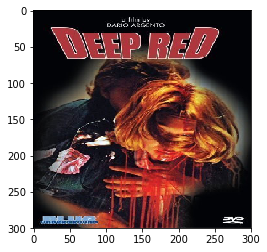

In [11]:
# Show one of the images
x, y = validation_generator.next()
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()

### 2.3 Model Building
There are essentially two routes we can take - either a pre-trained winner of ImageNet like AlexNet, GoogleNet, VGG. A pre-trained model may give better results, however for the fun of it I will try to create a custom architecture.

Let's try a simple architecture at first and then we can improve upon it.

Update after *[1st Run]* - It seems that the model fails to generalize and underfits with only 27% of accuracy. 

Architectures:  
*[1st Run]*
1. 4 convolutional layers, 3x3 with the default stride of 1, separated by two MaxPools of 2x2 layers encoding layers
2. 3 Fully connected layers - all multiples of the total number of genres.
3. The final layer - 'Sigmoid' to get the probabilities of the different genres.  


*[2nd Run]*
1. Add an additional layer of filters between each *maxpool* with the idea to get more features. Also add an additional fully connected model.

In [12]:
# The model
classifier = Sequential()
classifier.add(Conv2D(32, (3,3), input_shape = (300, 300, 3), activation = 'relu'))
classifier.add(Conv2D(32, (3,3), activation = 'relu'))
classifier.add(Conv2D(32, (3,3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Conv2D(64, (3,3), activation = 'relu'))
classifier.add(Conv2D(64, (3,3), activation = 'relu'))
classifier.add(Conv2D(64, (3,3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Flatten())
classifier.add(Dense(units = 115, activation = 'relu'))
classifier.add(Dense(units = 69, activation = 'relu'))
classifier.add(Dense(units = 69, activation = 'relu'))
classifier.add(Dense(units = 23, activation = 'softmax'))

In [13]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 296, 296, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 294, 294, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 147, 147, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 145, 145, 64)      18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 143, 143, 64)      36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 141, 141, 64)      36928     
__________

#### Choosing an optimizer: [Why is ADAM the optimizer?](https://arxiv.org/pdf/1609.04747.pdf)

In [14]:
# Compile the model
classifier.compile(optimizer = 'adam', 
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

In [15]:
classifier.save('./movie_genre_prediction/models/clf_untrained.model')

In [16]:
# classifier fit example
classifier.fit_generator(train_generator,
                         steps_per_epoch = 1000,
                         epochs = 2,
                         validation_data = test_generator,
                         validation_steps = 200)

Epoch 1/2
1000/1000 [==============================] - 150s 150ms/step - loss: 2.3732 - acc: 0.2731 - val_loss: 2.3629 - val_acc: 0.2781
Epoch 2/2
1000/1000 [==============================] - 147s 147ms/step - loss: 2.3463 - acc: 0.2762 - val_loss: 2.4266 - val_acc: 0.2581


#### Results
I will record all of the results here, in order to not make this notebook endless.

* [1st run] (2xConv2D(32, (3x3); maxpool, 2xConv2D(64, (3x3)), maxpool, 3 full connected layers - 2.31 loss; 0.27 accuracy.
* [2nd run] (3xConv2D(32, (3x3); maxpool, 3xConv2D(64, (3x3)), maxpool, 4 full connected layers - 2.33 loss; 0.27 accuracy.

In [3]:
classifier_trained = load_model('./movie_genre_prediction/models/clf_trained.model')

Very low accuracy, a little bit above random picking... Bias needs to be improved. But first - let's create a validation set.

**[2st run]**

In [8]:
classifier_trained.evaluate_generator(test_generator, steps = 12400, max_queue_size=10, verbose=1)

12400/12400 [==============================] - 504s 41ms/step


[2.3368871899478783, 0.2757748069317023]